# 5. Nonlinear Differential Equations 

In [1]:
import numpy as np

from scipy.linalg import solve

import matplotlib.pyplot as plt

In [2]:
def FourierD(N):
    row = np.arange(N)[:, None]
    col = np.arange(N)[None, :]
    x = 2 * np.pi * row / N
    h = (x[1] - x[0])[0]
    center = - np.pi**2 / (3 * h**2) - 1 / 6
    D1 = (row != col) * 0.5 * (-1)**(row + col) / np.tan(0.5 * ((row - col) * h) + (row == col))
    D2 = (row != col) * 0.5 * (-1)**(row + col + 1) / np.sin(0.5 * ((row - col) * h) + (row == col))**2 + center * (row == col)
    return x, D1, D2

def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x = np.cos(np.pi * row / N)
    c = ((1 + (col % N == 0)) * (-1) ** col).T
    X = np.ones(N + 1) * x
    dX = X - X.T
    D = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

## 5.1 Nonlinear Ordinary Differential Equation

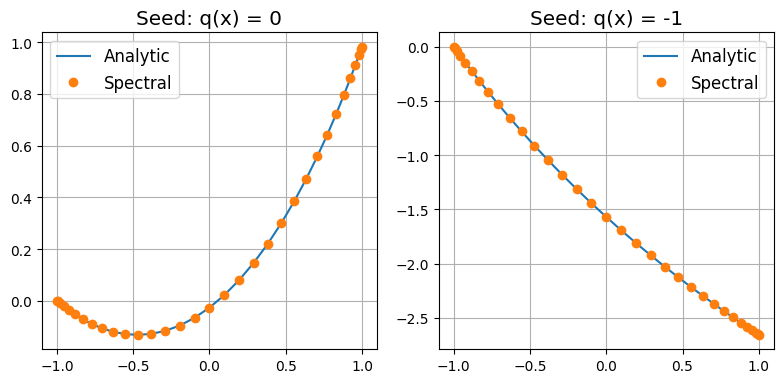

In [3]:
N = 32
x, D1, D2 = ChebyshevD(N)
I = np.eye(N+1)

params = [(0.483794, 0.472301), (0.110278, -11.2273)]
solutions = np.zeros((N + 1, 2))

for sol in range(2):
    q = 0 * x - sol
    dq_max = 100
    while dq_max > 1e-6:
    
        # Linearized differential equation
        A = D2 - np.diag(0.5 * np.exp(0.5 * q[:, 0]))
        b = D2 @ q - np.exp(0.5 * q)
        
        # Boundary conditions at x = -1
        A[-1, :] = I[-1, :]
        b[-1, :] = q[-1, :]
        
        # Boundary conditions at x = +1
        A[0, :] = (D1 - np.diag(np.exp(q[:, 0])))[0, :]
        b[0, :] = (D1 @ q - np.exp(q) + 1)[0, :]
        
        dq = solve(A, b)
        q -= dq
        
        dq_max = np.max(dq**2)
        
    solutions[:, [sol]] = q

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (8, 4));
plt.rc('font', size = 12)

for i in range(2):
    A, B = params[i]
    ax[i].plot(x, 4 * np.log(2 * A / np.cos(A * (x + B) ) ), label = 'Analytic')
    ax[i].plot(x, solutions[:, i], 'o', label = 'Spectral')
    ax[i].set_title(f'Seed: q(x) = {-i}')
    ax[i].legend()
    ax[i].grid()

plt.tight_layout()
################################################################################

## 5.2 Nonlinear Partial Differential Equation

In [44]:
N = 20
x, D1, D2 = FourierD(N)

v_sq, u_sq = np.meshgrid(x, x)
u = u_sq.reshape(N**2, 1)
v = v_sq.reshape(N**2, 1)

Du = np.kron(D1, np.eye(N))
Dv = np.kron(np.eye(N), D1)
I  = np.eye(N**2)

def relax(R_guess, gamma, k):
    
    R = R_guess.copy()
    dR_max = 100
    
    while dR_max > 1e-5:
        Ru = Du @ R; Ruu = Du @ Ru
        Rv = Dv @ R; Rvv = Dv @ Rv
        Ruv = Dv @ Ru; Rud = np.diag(Ru[:,0]); Rvd = np.diag(Rv[:,0])

        rhs  = R + 0.5 * k**2 * (Ru**2 + Rv**2 + 2 * Ruu + 2 * Rvv - 2 * gamma * Ru * Rv - 4 * gamma * Ruv)
        J = I + k**2 * (Du @ Du + Dv @ Dv + Rud @ Du + Rvd @ Dv - gamma * (2 *  Du @ Dv + Rud @ Dv + Rvd @ Du))

        dR = solve(J, rhs)
        R -= dR
        
        dR_max = np.max(np.abs(rhs))
        
    return R

In [45]:
def plot_xy(R, gamma, k, fig, ax):
    R_sq   = R.reshape(N, N)
    u_sq_l = np.concatenate([u_sq - 4*np.pi, u_sq - 2*np.pi, u_sq, u_sq + 2*np.pi, u_sq + 4*np.pi],   axis = 0)
    u_sq_l = np.concatenate([u_sq_l, u_sq_l, u_sq_l, u_sq_l, u_sq_l], axis = 1)
    v_sq_l = np.concatenate([v_sq, v_sq, v_sq, v_sq, v_sq],   axis = 0)
    v_sq_l = np.concatenate([v_sq_l - 4*np.pi, v_sq_l - 2*np.pi, v_sq_l, v_sq_l + 2*np.pi, v_sq_l + 4*np.pi], axis = 1)
    R_sq_l = np.concatenate([R_sq, R_sq, R_sq, R_sq, R_sq],   axis = 0)
    R_sq_l = np.concatenate([R_sq_l, R_sq_l, R_sq_l, R_sq_l, R_sq_l], axis = 1)

    x = (u_sq_l + gamma*v_sq_l)/(k*np.sqrt(1-gamma**2))
    y = v_sq_l/k
    
    cf = ax.contourf(x, y, np.exp(R_sq_l))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    fig.colorbar(cf, ax=ax)

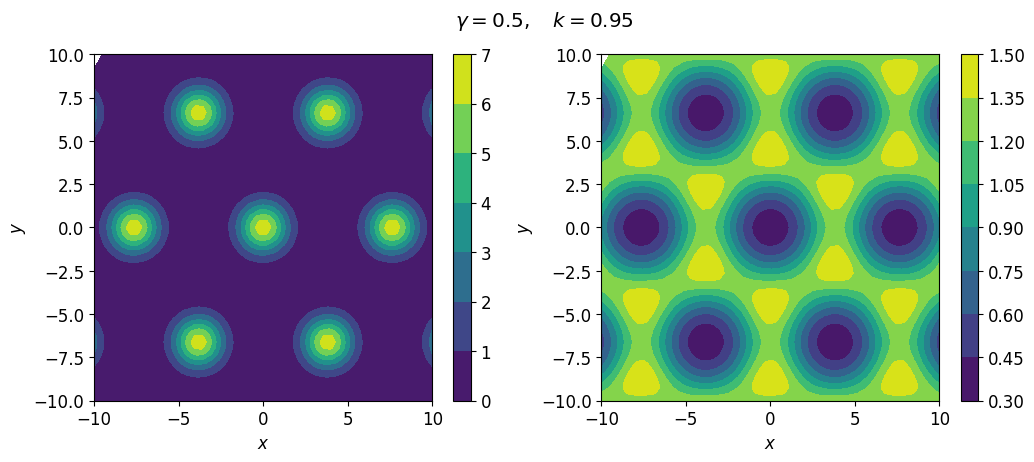

In [46]:
gamma = 0.5
k = 0.95

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
plt.rc('font', size = 12)

R_hex = -1 * (np.cos(u) + np.cos(v))
R_tri =  3 * (np.cos(u) + np.cos(v))
R_hex = relax(R_hex, gamma, k)
R_tri = relax(R_tri, gamma, k)

fig.suptitle(f'$\gamma = {gamma}, \quad k = {k}$')

plot_xy(R_tri, gamma, k, fig, ax[0])
plot_xy(R_hex, gamma, k, fig, ax[1])

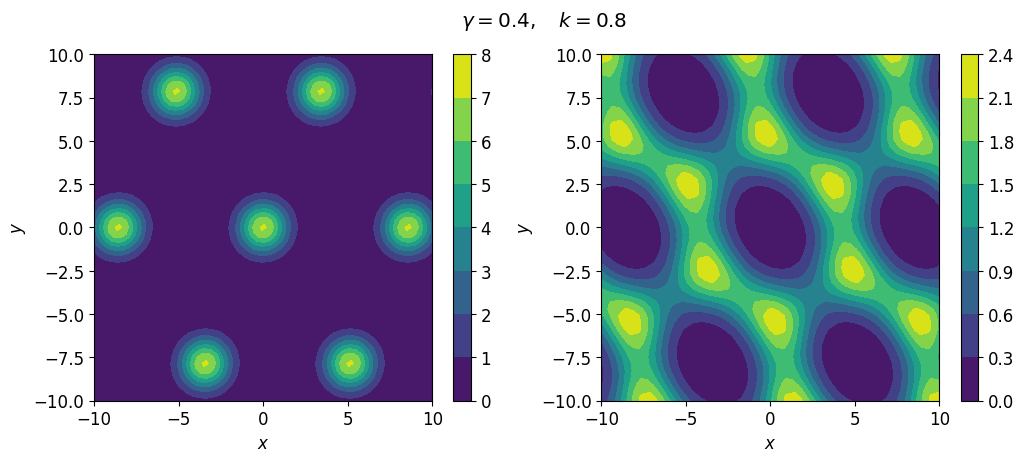

In [47]:
gamma = 0.4
k = 0.8

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
plt.rc('font', size = 12)

R_hex = -1 * (np.cos(u) + np.cos(v))
R_tri =  3 * (np.cos(u) + np.cos(v))
R_hex = relax(R_hex, gamma, k)
R_tri = relax(R_tri, gamma, k)

fig.suptitle(f'$\gamma = {gamma}, \quad k = {k}$')

plot_xy(R_tri, gamma, k, fig, ax[0])
plot_xy(R_hex, gamma, k, fig, ax[1])